In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
setwd("~/Repositories/AirQualityCOVID/")
source("src/functions.R")

In [4]:
nn.cluster <- read.csv("data/Clustering/groups.csv")

data.df <- merge(read.csv("data/Results/predictions_municipios.csv"),
                 nn.cluster,
                 by = "Municipio", all.x=T, sort=F
                ) %>%
            data.as.datetime("date", FUN="ymd") %>%
            mutate(group=as.factor(group)) %>%
            group_by(date, group) %>%
            summarise(mean = mean(diff, na.rm=T),
                      qnt.75 = quantile(diff, 0.75, na.rm=T),
                      qnt.25 = quantile(diff, 0.25, na.rm=T),
                      n = n()
                     ) %>% data.frame()

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



Warning message:
“Removed 120 row(s) containing missing values (geom_path).”
Warning message:
“Removed 120 row(s) containing missing values (geom_path).”


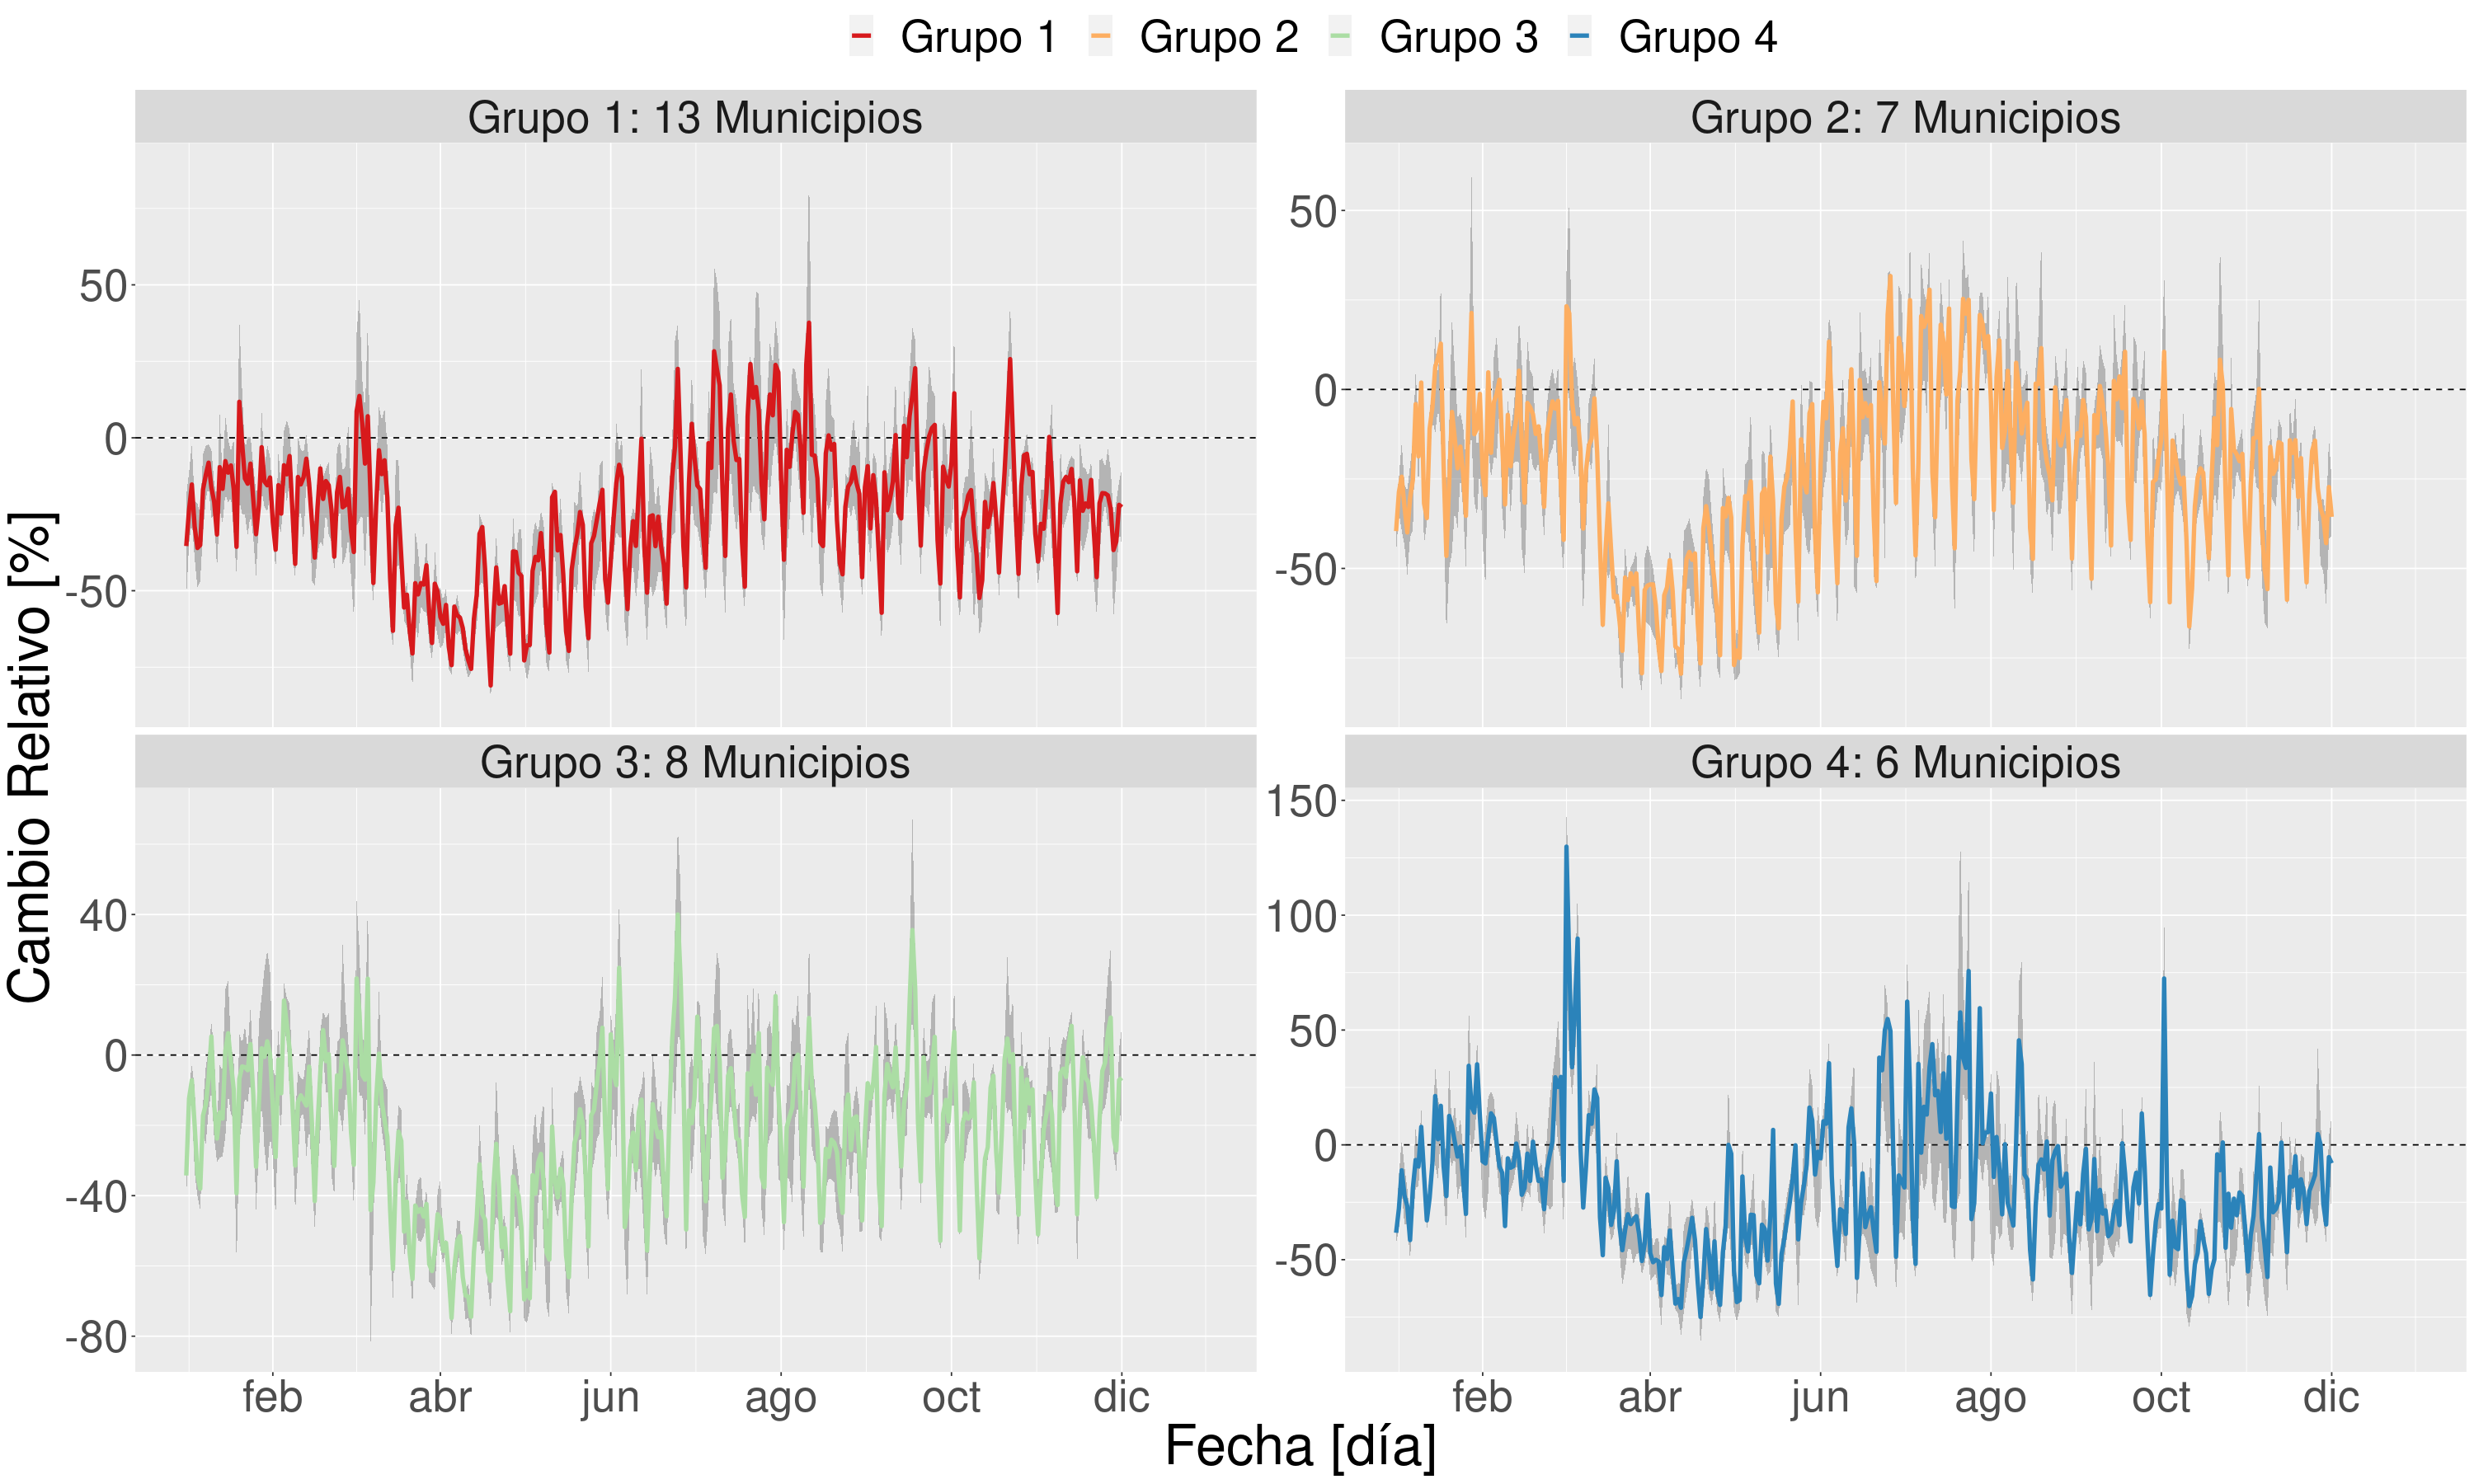

In [5]:
plt.clusters <- ggplot(data.df, aes(date)) +
            geom_hline(yintercept=0, 
                       linetype="dashed", 
                       color = "black") +
    geom_ribbon(aes(ymin=qnt.25,ymax=qnt.75),
                alpha=0.3) +
    geom_line(aes(y=mean, color=group), size=1.5) +
    theme(legend.position="top",
          text = element_text(size=40),
         ) +
    scale_x_date(name="Fecha [día]",
         date_breaks = "2 month",
         date_labels = "%b") +
    scale_color_brewer(name="", palette="Spectral",
                       labels = c("1" = "Grupo 1", 
                                  "2" = "Grupo 2", 
                                  "3" = "Grupo 3", 
                                  "4" = "Grupo 4")) +
    scale_y_continuous(name="Cambio Relativo [%]") +
    facet_wrap(~group, scale="free_y", 
               labeller = labeller(group=c("1" = paste("Grupo 1: 13 Municipios"), 
                                           "2" = paste("Grupo 2: 7 Municipios"), 
                                           "3" = paste("Grupo 3: 8 Municipios"), 
                                           "4" = paste("Grupo 4: 6 Municipios"))))

ggsave(plot = plt.clusters, 
       "Plots/Clustering/clusters.png", 
       width =25, height = 10)

plt.clusters

In [6]:
library(leaflet)
library(leaflet.extras)
library(htmlwidgets)
library(htmltools)

In [7]:
sites <- read.csv("data/Curation/checked_AQ.csv") %>%
            group_by(Municipio) %>%
            summarise(latitude = mean(latitude, na.rm=T),
                      longitude = mean(longitude, na.rm=T))

sites.group <- merge(sites,
                     nn.cluster,
                     by = c("Municipio")
                    ) %>% mutate(group = as.character(group))# %>%
                    #replace(group == "1", "1: 13 Municipios")


sites.group[sites.group$group == "1", "group"] <- "1: 13 Municipios"
sites.group[sites.group$group == "2", "group"] <- "2: 7 Municipios"
sites.group[sites.group$group == "3", "group"] <- "3: 8 Municipios"
sites.group[sites.group$group == "4", "group"] <- "4: 6 Municipios"

In [8]:
beatCol <- colorFactor(palette = "Spectral", #'RdYlGn',
                        domain = sites.group$group,
                        na.color = "transparent",
                        reverse = F,
                        
                       )

map <- leaflet(sites.group,
               options = leafletOptions(minZoom = 5, 
                                        maxZoom = 9)) %>%
            addProviderTiles(providers$CartoDB.Positron)%>% 
            addCircleMarkers(~longitude, 
                             ~latitude, 
                             color=~beatCol(group),
                             radius=10,
                             fillOpacity=0.9,
                             stroke=FALSE,
                             popup = paste(sites.group$Municipio, ": ", sep="")
                            )%>%
            addLegend("bottomright", 
                       pal = beatCol, 
                       values = ~group,
                       title = "Grupos",
                       labFormat = labelFormat(prefix = "Grupo "),
                       opacity = 1,
                       )

map

HTML widgets cannot be represented in plain text (need html)

In [9]:
library(htmlwidgets)
saveWidget(map, file=paste("~/Repositories/AirQualityCOVID/",
                           "Plots/Clustering/clusters.html", sep=""))

### Lockdown dates

In [10]:
periods <- list(
            # Prelockdown
            #"pre Confinamiento" = lubridate::ymd("2020-01-01"),

            # lockdown
            "Confinamiento" = lubridate::ymd("2020-03-14"),
            #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

            # poslockdown
            "Fases" = lubridate::ymd("2020-05-01"),
            "Nueva Normalidad" = lubridate::ymd("2020-06-21"),

            # New lockdown
            "Segundo Estado de Alarma" = lubridate::ymd("2020-10-25")
            #end.year = lubridate::ymd("2020-12-31")
        )

In [11]:
get.breakpoints <- function(serie, label) {
    a <- strucchange::breakpoints(
        mean ~ date, 
        data = serie, 
        h = 15, 
        breaks = 4
      )
    
    breakpoints <- data.frame("date" = serie[a$breakpoints, "date"],
                              "group"=label
                             )# %>% rename(breaks = date)
}

In [12]:
b <- data.frame()

for (gr in levels(data.df$group)) {

    data <- data.df %>% filter(group == gr)

    b <- rbind(b, get.breakpoints(data, gr))
}

Warning message:
“Removed 120 row(s) containing missing values (geom_path).”
Warning message:
“Removed 120 row(s) containing missing values (geom_path).”


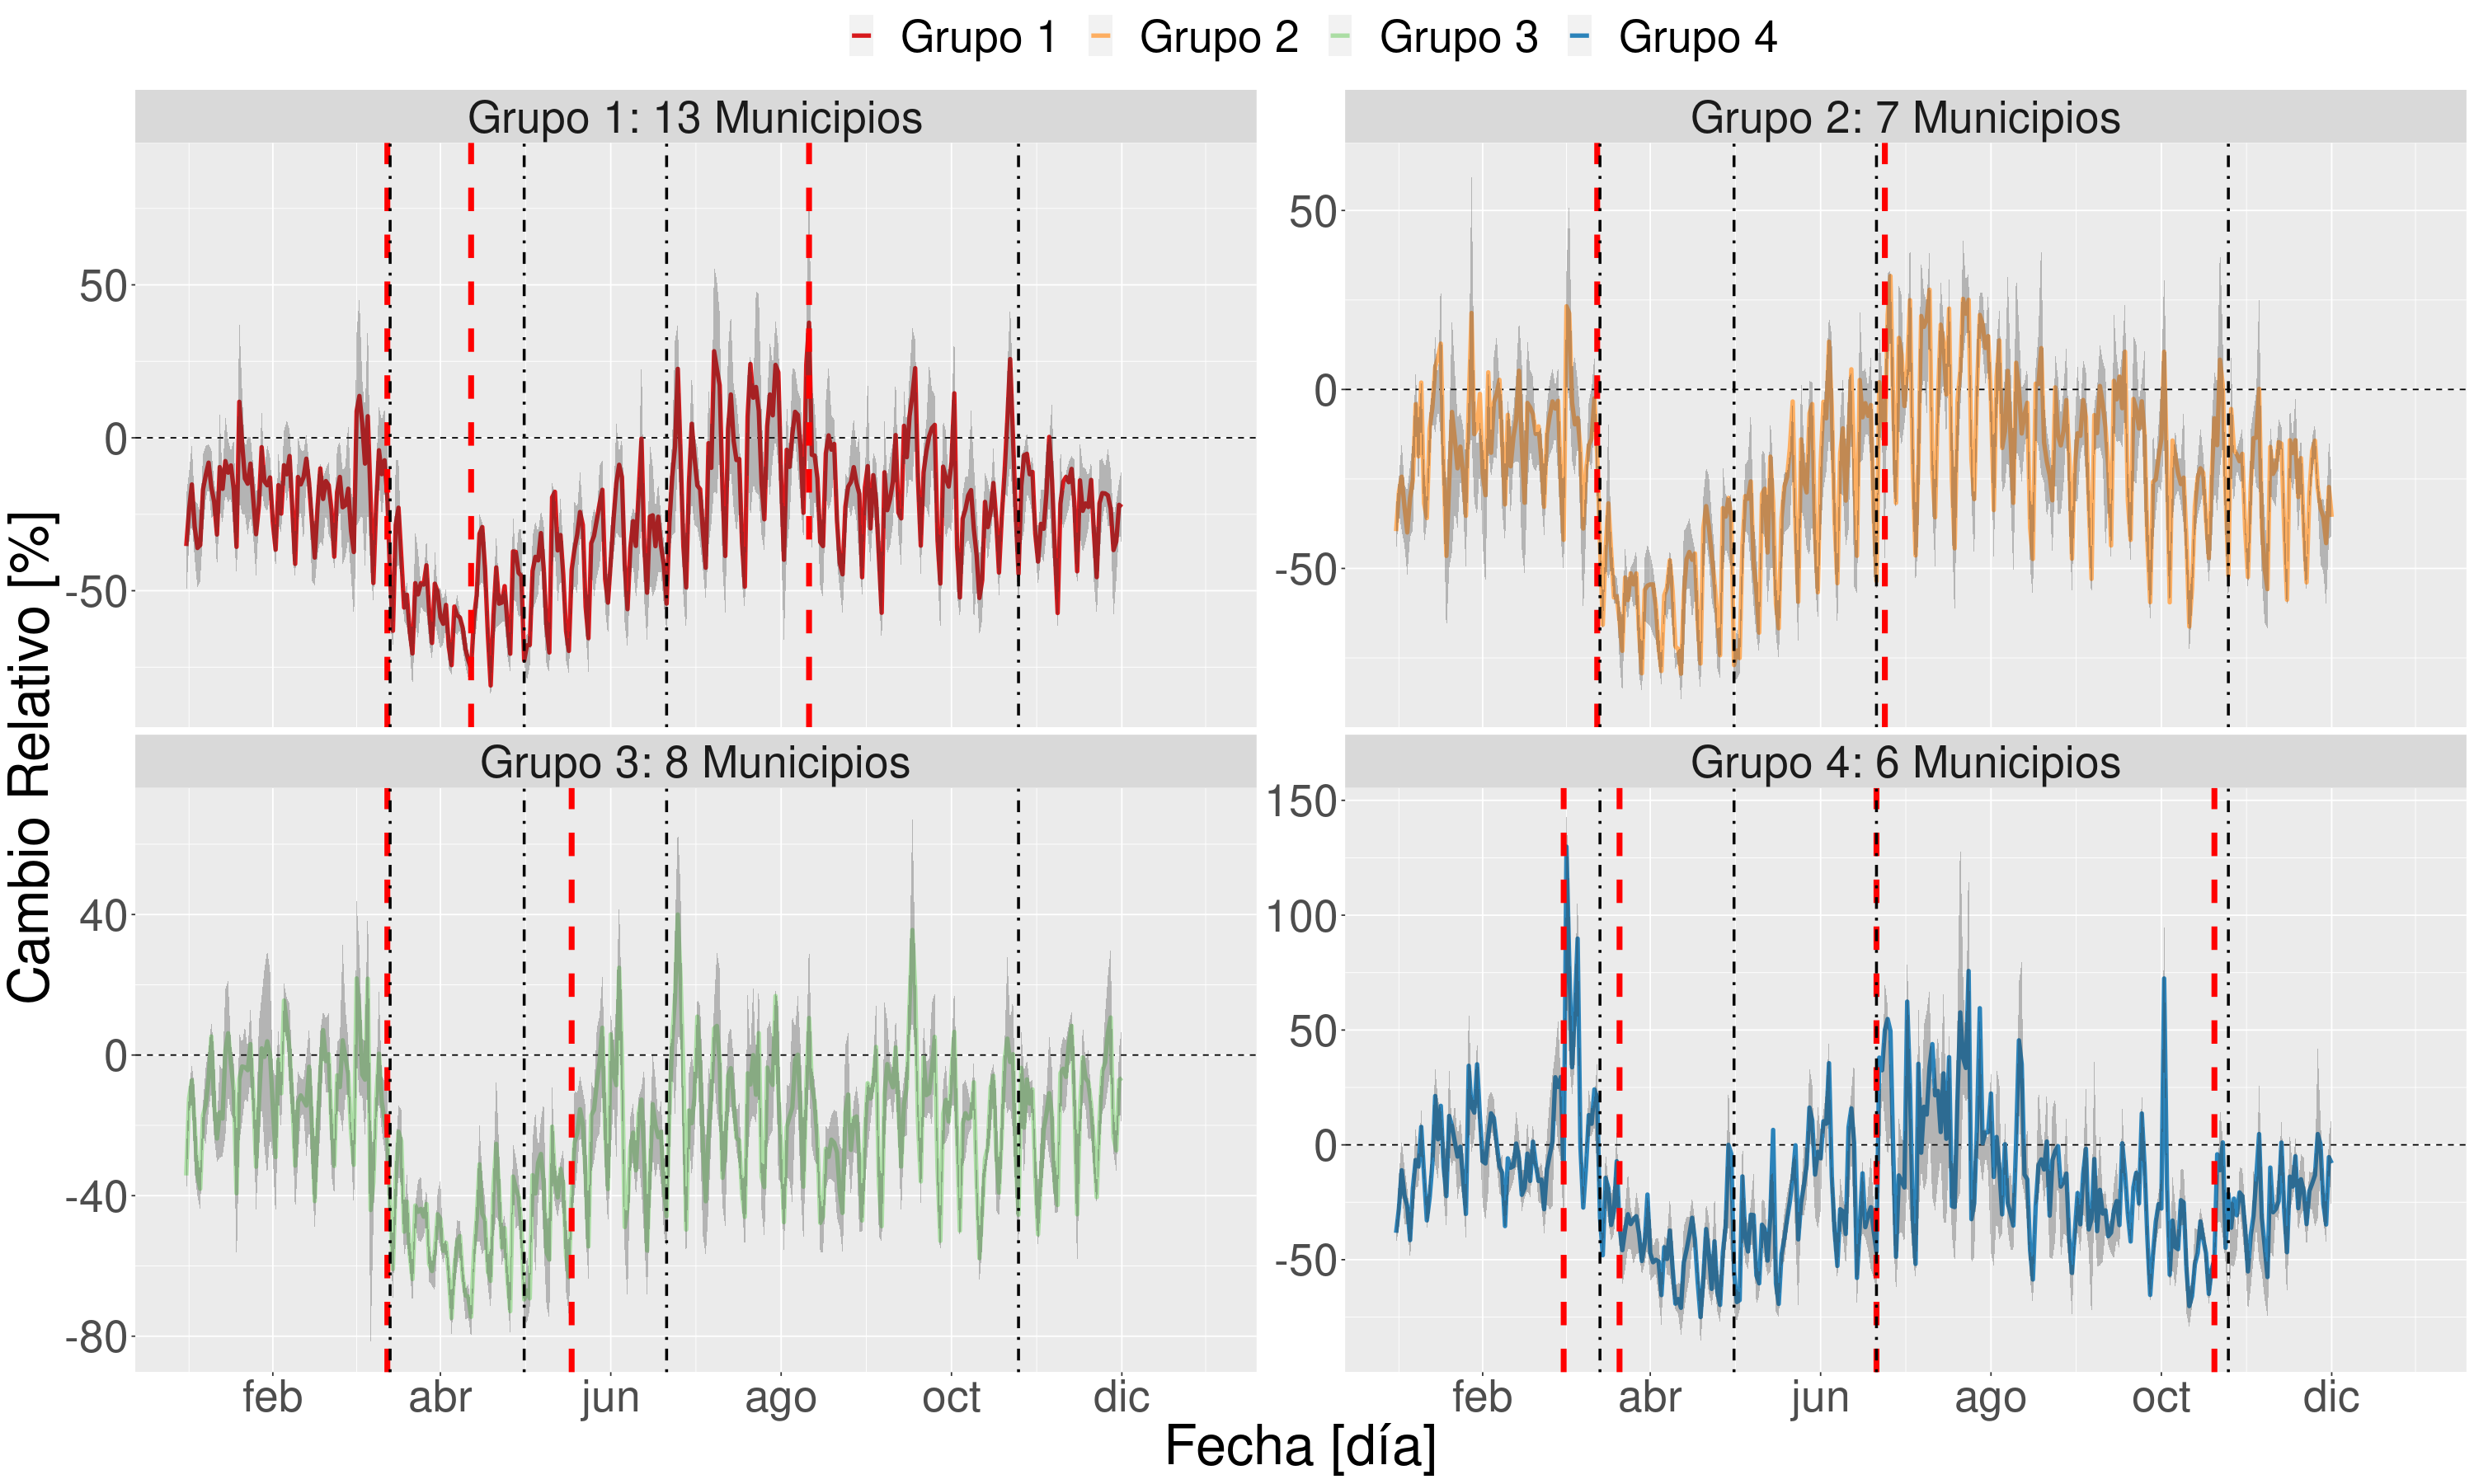

In [18]:
plt.breakpoints <- ggplot(data.df, aes(date)) +
            geom_hline(yintercept=0, 
                       linetype="dashed", 
                       color = "black") +
    geom_line(aes(y=mean, color=group), size=1.5) +
    geom_ribbon(aes(ymin=qnt.25,ymax=qnt.75),
                alpha=0.3) +
    geom_vline(data = b, aes(xintercept = date), color="red", 
               linetype=2, size=2)+
    geom_vline(xintercept = unlist(periods), 
               linetype=4, color = "black", size=1)+
    #geom_ribbon(aes(ymin=qnt.25,ymax=qnt.75),
    #            alpha=0.3) +
    theme(legend.position="top",
          text = element_text(size=40),
         ) +
    scale_x_date(name="Fecha [día]",
         date_breaks = "2 month",
         date_labels = "%b") +
    scale_color_brewer(name="", palette="Spectral",
                       labels = c("1" = "Grupo 1", 
                                  "2" = "Grupo 2", 
                                  "3" = "Grupo 3", 
                                  "4" = "Grupo 4")) +
    scale_y_continuous(name="Cambio Relativo [%]") +
    facet_wrap(~group, scale="free_y", 
               labeller = labeller(group=c("1" = paste("Grupo 1: 13 Municipios"), 
                                           "2" = paste("Grupo 2: 7 Municipios"), 
                                           "3" = paste("Grupo 3: 8 Municipios"), 
                                           "4" = paste("Grupo 4: 6 Municipios"))))

ggsave(plot = plt.breakpoints, 
       "Plots/Clustering/breakpoints.png", 
       width = 30, height = 15)

plt.breakpoints

In [14]:
per <- data.frame(periods = names(periods),
                  date.ref = c(unlist(periods)))

In [15]:
break.points <- data.frame()

for (i in 1:4) {
    q <- b %>% filter(group==i) %>%
            mutate(group = paste("Grupo", group))
    
    break.points <- rbind(break.points,
                          cbind(per %>% slice(1:nrow(q)),q))
}

In [16]:
break.points %>%
            mutate(date.ref = lubridate::as_date(date.ref)) %>%
            pivot_wider(names_from = group, values_from = date)

periods,date.ref,Grupo 1,Grupo 2,Grupo 3,Grupo 4
<chr>,<date>,<date>,<date>,<date>,<date>
Confinamiento,2020-03-14,2020-03-13,2020-03-13,2020-03-13,2020-03-01
Fases,2020-05-01,2020-04-12,2020-06-24,2020-05-18,2020-03-21
Nueva Normalidad,2020-06-21,2020-08-11,NA,NA,2020-06-21
Segundo Estado de Alarma,2020-10-25,NA,NA,NA,2020-10-20


In [17]:
write.csv(break.points %>%
            mutate(date.ref = lubridate::as_date(date.ref)) %>%
            pivot_wider(names_from = group, values_from = date),
          "data/Clustering/breakpoints.csv",
          row.names=F) 